# メモ


* LSTM*3 +
* epoch=200,+,1.037
* dropout=0.1 - 
* H=500 - 
* self.batch_norm = nn.BatchNorm1d(H) - 
* lr=0.01 -
* lr=0.1 -
* LSTM*5 -
* LSTM*4  +, 1.019
* self.dropout = nn.Dropout(p=0.2) を追加, 



# 準備

In [ ]:
# 必要なパッケージのインストール
!pip3 install torch==1.6.0+cu101
!pip3 install torchvision==0.7.0+cu101
!pip3 install numpy==1.18.5
!pip3 install matplotlib==3.2.2
!pip3 install scikit-learn==0.23.1
!pip3 install seaborn==0.11.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement torch==1.6.0+cu101 (from versions: 1.4.0, 1.5.0, 1.5.1, 1.6.0, 1.7.0, 1.7.1, 1.8.0, 1.8.1, 1.9.0, 1.9.1, 1.10.0, 1.10.1, 1.10.2, 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1)
ERROR: No matching distribution found for torch==1.6.0+cu101
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement torchvision==0.7.0+cu101 (from versions: 0.1.6, 0.1.7, 0.1.8, 0.1.9, 0.2.0, 0.2.1, 0.2.2, 0.2.2.post2, 0.2.2.post3, 0.5.0, 0.6.0, 0.6.1, 0.7.0, 0.8.0, 0.8.1, 0.8.2, 0.9.0, 0.9.1, 0.10.0, 0.10.1, 0.11.0, 0.11.1, 0.11.2, 0.11.3, 0.12.0, 0.13.0, 0.13.1, 0.14.0, 0.14.1)
ERROR: No matching distribution found for torchvision==0.7.0+cu101
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in in

In [ ]:
# モジュールのインポート
import numpy as np
import pandas as pd
import pandas_datareader.data as data
from matplotlib import pyplot as plt
%matplotlib inline

# 標準化関数（StandardScaler）をインポート
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import torch.nn.functional as F
from torch import optim

import pandas.tseries.offsets as offsets

# 設定1

In [ ]:
n=100

# データの準備・前処理

In [ ]:
start = '2005-01-01'
end = '2023-01-01'

df = data.DataReader('^NKX', 'stooq', start, end)
df=df.reset_index()

In [ ]:
# 始値(open)、安値(low)、高値(high)、出来高(volume)を消して、終値(close)のみを残す
df = df.drop(['Open', 'Low', 'High', 'Volume'], axis=1)
df.sort_values(by='Date', ascending=True, inplace=True)
df.head()

,Date,Close
4406,2005-01-04,11517.75
4405,2005-01-05,11437.52
4404,2005-01-06,11492.26
4403,2005-01-07,11433.24
4402,2005-01-11,11539.99


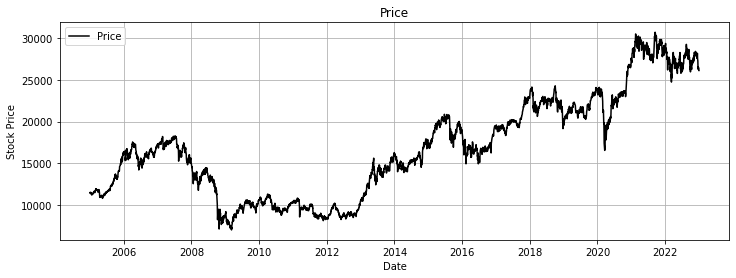

In [ ]:
# 株価を図示

fig=plt.figure(figsize=(12,4))
plt.title('Price')
plt.xlabel('Date')
plt.ylabel('Stock Price')

plt.plot(df['Date'], df['Close'], color='black', label='Price')

plt.grid(True)
plt.legend(loc = 'upper left')  # 凡例
plt.show()

In [ ]:
# 標準化
ma = df['Close'].values.reshape(-1, 1)
scaler = StandardScaler()
ma_std = scaler.fit_transform(ma)
print("ma: {}".format(ma))
print("ma_std: {}".format(ma_std))

ma: [[11517.75]
 [11437.52]
 [11492.26]
 ...
 [26340.5 ]
 [26093.67]
 [26094.5 ]]
ma_std: [[-0.88699625]
 [-0.90030737]
 [-0.89122535]
 ...
 [ 1.57227622]
 [ 1.53132416]
 [ 1.53146186]]


In [ ]:
data = []  # 入力データ(過去n日分の株価)
label = []  # 出力データ(1日後の株価)
for i in range(len(ma_std) - n):
    data.append(ma_std[i:i + n])
    label.append(ma_std[i + n])
# ndarrayに変換
data = np.array(data)
label = np.array(label)
print("data size: {}".format(data.shape))
print("label size: {}".format(label.shape))

data size: (4307, 100, 1)
label size: (4307, 1)


In [ ]:
# 訓練データとテストデータのサイズを決定
test_len = int(255)  # 1年分
train_len = int(data.shape[0] - test_len)
# 訓練データの準備
train_data = data[:train_len]
train_label = label[:train_len]
# テストデータの準備
test_data = data[train_len:]
test_label = label[train_len:]
# データの形状を確認
print("train_data size: {}".format(train_data.shape))
print("test_data size: {}".format(test_data.shape))
print("train_label size: {}".format(train_label.shape))
print("test_label size: {}".format(test_label.shape))

train_data size: (4052, 100, 1)
test_data size: (255, 100, 1)
train_label size: (4052, 1)
test_label size: (255, 1)


In [ ]:
# ndarrayをPyTorchのTensorに変換
train_x = torch.Tensor(train_data)
test_x = torch.Tensor(test_data)
train_y = torch.Tensor(train_label)
test_y = torch.Tensor(test_label)

In [ ]:
# 特徴量とラベルを結合したデータセットを作成
train_dataset = TensorDataset(train_x, train_y)
test_dataset = TensorDataset(test_x, test_y)

In [ ]:
# ミニバッチサイズを指定したデータローダーを作成
train_batch = DataLoader(
    dataset=train_dataset,  # データセットの指定
    batch_size=128,  # バッチサイズの指定
    shuffle=True,  # シャッフルするかどうかの指定
    num_workers=2)  # コアの数
test_batch = DataLoader(
    dataset=test_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=2)
# ミニバッチデータセットの確認
for data, label in train_batch:
    print("batch data size: {}".format(data.size()))  # バッチの入力データサイズ
    print("batch label size: {}".format(label.size()))  # バッチのラベルサイズ
    break

batch data size: torch.Size([128, 100, 1])
batch label size: torch.Size([128, 1])


# 簡易学習設定


In [ ]:
H = 200  # 隠れ層次元
epoch = 100  # 学習回数
layer=3 # LSTMのレイヤー数

# 学習

In [ ]:
# ニューラルネットワークの定義
class Net(nn.Module):
    def __init__(self, D_in, H, D_out,layer):
        super(Net, self).__init__()
        self.lstm = nn.LSTM(D_in, H, batch_first=True,
                            num_layers=layer)
        self.linear = nn.Linear(H, D_out)
        self.batch_norm = nn.BatchNorm1d(H)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        output, (hidden, cell) = self.lstm(x)
        output=output[:, -1, :].squeeze()
        # output = self.batch_norm(output)
        # output = self.linear(output)
        # output=self.dropout(output[:, -1, :].squeeze())
        output = self.linear(output)  # 最後のステップのみを入力
        return output

In [ ]:
D_in = 1  # 入力次元
D_out = 1  # 出力次元

In [ ]:
# ネットワークのロード
# CPUとGPUどちらを使うかを指定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Net(D_in, H, D_out,layer).to(device)
# デバイスの確認
print("Device: {}".format(device))

Device: cuda


In [ ]:
# 損失関数の定義
criterion = nn.MSELoss()  # 損失関数（平均二乗誤差: MSE）

# 最適化関数の定義
optimizer = optim.Adam(net.parameters())

In [ ]:
# 損失を保存するリストを作成
train_loss_list = []  # 学習損失
test_loss_list = []  # 評価損失

# 学習（エポック）の実行
for i in range(epoch):
    # エポックの進行状況を表示
    print('---------------------------------------------')
    print("Epoch: {}/{}".format(i+1, epoch))

    # 損失の初期化
    train_loss = 0  # 学習損失
    test_loss = 0  # 評価損失

    # ---------学習パート--------- #
    # ニューラルネットワークを学習モードに設定
    net.train()
    # ミニバッチごとにデータをロードし学習
    for data, label in train_batch:
        # GPUにTensorを転送
        data = data.to(device)
        label = label.to(device)
        
        # 勾配を初期化
        optimizer.zero_grad()
        # データを入力して予測値を計算（順伝播）
        y_pred = net(data)
        # 損失（誤差）を計算
        loss = criterion(y_pred, label)
        # 勾配の計算（逆伝搬）
        loss.backward()
        # パラメータ（重み）の更新
        optimizer.step()
        # ミニバッチごとの損失を蓄積
        train_loss += loss.item()

    # ミニバッチの平均の損失を計算
    batch_train_loss = train_loss / len(train_batch)
    # ---------学習パートはここまで--------- #

    # ---------評価パート--------- #
    # ニューラルネットワークを評価モードに設定
    net.eval()
    # 評価時の計算で自動微分機能をオフにする
    with torch.no_grad():
        for data, label in test_batch:
            # GPUにTensorを転送
            data = data.to(device)
            label = label.to(device)
            print(data.shape)
            # データを入力して予測値を計算（順伝播）
            y_pred = net(data)
            # 損失（誤差）を計算
            loss = criterion(y_pred, label)
            # ミニバッチごとの損失を蓄積
            test_loss += loss.item()

    # ミニバッチの平均の損失を計算
    batch_test_loss = test_loss / len(test_batch)
    # ---------評価パートはここまで--------- #

    # エポックごとに損失を表示
    print("Train_Loss: {:.2E} Test_Loss: {:.2E}".format(
        batch_train_loss, batch_test_loss))
    # 損失をリスト化して保存
    train_loss_list.append(batch_train_loss)
    test_loss_list.append(batch_test_loss)

  








---------------------------------------------
Epoch: 1/100
torch.Size([128, 100, 1])
torch.Size([127, 100, 1])
Train_Loss: 1.97E-01 Test_Loss: 2.52E-02
---------------------------------------------
Epoch: 2/100
torch.Size([128, 100, 1])
torch.Size([127, 100, 1])
Train_Loss: 9.98E-03 Test_Loss: 1.44E-02
---------------------------------------------
Epoch: 3/100
torch.Size([128, 100, 1])
torch.Size([127, 100, 1])
Train_Loss: 6.52E-03 Test_Loss: 1.58E-02
---------------------------------------------
Epoch: 4/100
torch.Size([128, 100, 1])
torch.Size([127, 100, 1])
Train_Loss: 6.07E-03 Test_Loss: 2.48E-02
---------------------------------------------
Epoch: 5/100
torch.Size([128, 100, 1])
torch.Size([127, 100, 1])
Train_Loss: 5.68E-03 Test_Loss: 1.21E-02
---------------------------------------------
Epoch: 6/100
torch.Size([128, 100, 1])
torch.Size([127, 100, 1])
Train_Loss: 5.62E-03 Test_Loss: 1.19E-02
---------------------------------------------
Epoch: 7/100
torch.Size([128, 100, 1])
tor

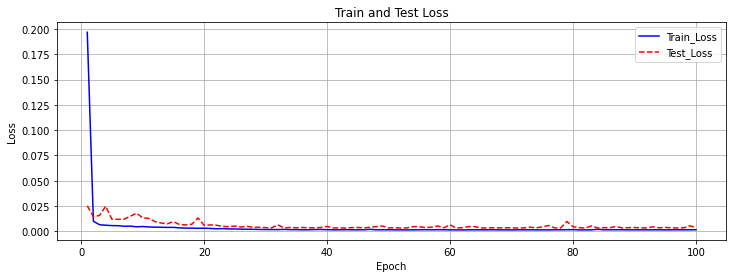

In [ ]:
# 損失
fig=plt.figure(figsize=(12,4))
plt.title('Train and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(1, epoch+1), train_loss_list, color='blue',
         linestyle='-', label='Train_Loss')
plt.plot(range(1, epoch+1), test_loss_list, color='red',
         linestyle='--', label='Test_Loss')
plt.legend()  # 凡例
plt.grid(True)
plt.show()  # 表示

In [ ]:
# ニューラルネットワークを評価モードに設定
net.eval()
# 推定時の計算で自動微分機能をオフにする
with torch.no_grad():
    # 初期化
    pred_ma = []
    true_ma = []
    for data, label in test_batch:
        # GPUにTensorを転送
        data = data.to(device)
        label = label.to(device)
        # データを入力して予測値を計算（順伝播）
        y_pred = net(data)
        pred_ma.append(y_pred.view(-1).tolist())  # Tensorを1次元listに変換
        true_ma.append(label.view(-1).tolist())

In [ ]:
# Tensorを数値データを取り出す
pred_ma = [elem for lst in pred_ma for elem in lst]  # listを1次元配列に
true_ma = [elem for lst in true_ma for elem in lst]

# 標準化を解除して元の株価に変換
pred_ma = scaler.inverse_transform(pred_ma)
true_ma = scaler.inverse_transform(true_ma)

# モデルの評価と比較

In [ ]:
# 平均絶対誤差を計算
mae = mean_absolute_error(true_ma, pred_ma)
print("MAE: {:.3f}".format(mae))

MAE: 317.977


<Figure size 864x288 with 0 Axes>

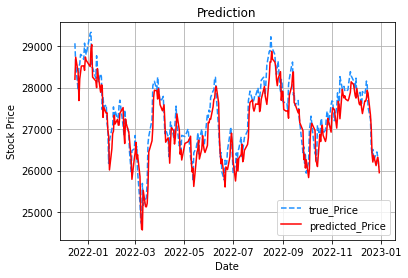

In [ ]:
# 終値と株価を図示
fig=plt.figure(figsize=(12,4))
date = df['Date'][-1*test_len:]  # テストデータの日付
test_close = df['Close'][-1*test_len:].values.reshape(-1)  # テストデータの終値
plt.figure()
plt.title('Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')

plt.plot(date, true_ma, color='dodgerblue',linestyle='--', label='true_Price')
plt.plot(date, pred_ma, color='red', label='predicted_Price')
plt.legend()  # 凡例
plt.grid(True)
# plt.xticks(rotation=30)
plt.show()

# 予測

In [ ]:
y=torch.FloatTensor(ma_std)
y=y.view(-1)
y=y.to(device)

In [ ]:
net.eval()
# 評価時の計算で自動微分機能をオフにする
with torch.no_grad():
  day = 30
  dfn = y[-n:]
  for i in range(day):
    dfna = dfn[-n:]
    # print(dfna)

    dfna = dfna.view(1, -1, 1)
    # print(dfna.shape)
    dfna = dfna.to(device)
    pred = net(dfna)
    pred = pred.reshape(1, -1, 1)
    dfn = torch.cat((dfn.view(1, -1, 1), pred), dim=1)
    dfn = dfn.squeeze()
    # print(dfn.shape)

In [ ]:
dfn = dfn.squeeze()

In [ ]:
y1=y.tolist()
dfn11=dfn.tolist()

In [ ]:
dfn1=dfn11[n:]

In [ ]:
len(dfn1)

30

In [ ]:
# 標準化を解除して元の株価に変換
true_dfn = scaler.inverse_transform(dfn1)

In [ ]:
# 直近のデータの最後の日付
df1= df.set_index("Date")
real_last_date_timestamp=df1.index[-1]

# 未来の最初の日付
future_first_date_timestamp=real_last_date_timestamp+offsets.Day()

# pandasのseriesに変換
future_first_date_series_datetime=pd.Series(future_first_date_timestamp)

# object型に変換
future_first_date_object=pd.Series(future_first_date_timestamp).astype(str)

# str型に変換
future_first_date_str=future_first_date_object[0]

future_first_date_str

'2022-12-31'

In [ ]:
# 未来の最後の日付の翌日の日付(Timestamp型)
second_argument_timestamp=future_first_date_timestamp+offsets.Day(day)

# 未来の最後の日付の翌日の日付(Seried datetime型)
second_argument_series_datetime=pd.Series(second_argument_timestamp)

# object型に変換
second_argument_object=pd.Series(second_argument_timestamp).astype(str)

# str型に変換
second_argument_str=second_argument_object[0]
second_argument_str

'2023-01-30'

In [ ]:
# 直近のデータを学習用に使う場合(test_size=30)
future_period=np.arange(future_first_date_str,second_argument_str,dtype="datetime64")

In [ ]:
len(future_period)

30

In [ ]:
# 直近のデータの最後の日付から3ヶ月ほど遡った日付(Timestamp)
plot_start_date_timestamp=real_last_date_timestamp+offsets.Day(-day*3)

<function matplotlib.pyplot.show(*args, **kw)>

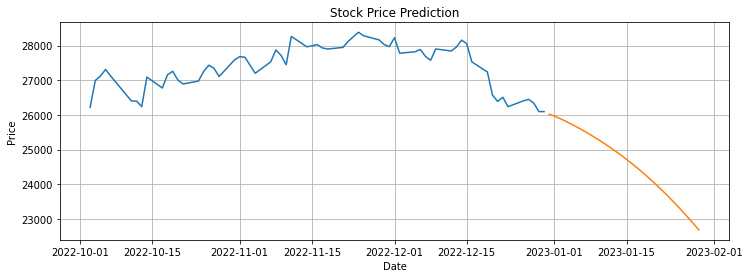

In [ ]:
# 作図
fig=plt.figure(figsize=(12,4))
plt.title("Stock Price Prediction")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)

plt.plot(df1["Close"][plot_start_date_timestamp:],label="Close")

plt.plot(future_period,true_dfn)
plt.show